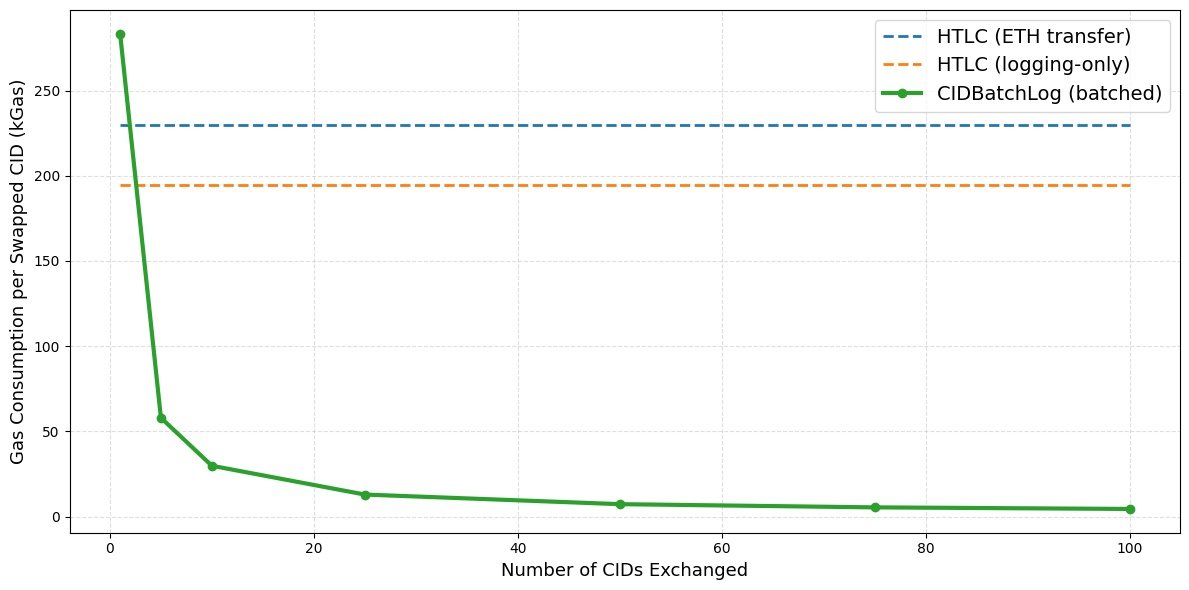

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path

# -----------------------------
# Measured HTLC values (from your tests)
# -----------------------------
HTLC_ETH_GAS_PER_CID = 229_567 / 1000  # kGas
HTLC_LOG_GAS_PER_CID = 194_319 / 1000  # kGas

# -----------------------------
# CIDBatchLog measurements (parsed from your log files)
# -----------------------------
LOG_FILES = [
    "cidbatchlog_1cids.log",
    "cidbatchlog_5cids.log",
    "cidbatchlog_10cids.log",
    "cidbatchlog_25cids.log",
    "cidbatchlog_50cids.log",
    "cidbatchlog_75cids.log",
    "cidbatchlog_100cids.log",
]

def parse_batch_size_from_name(name: str) -> int:
    m = re.search(r"_(\d+)cids\.log$", name)
    if not m:
        raise ValueError(f"Could not parse batch size from filename: {name}")
    return int(m.group(1))

def parse_total_gas_from_log(text: str) -> int:
    # Expected lines like:
    # create gasUsed: 175629
    # release gasUsed: 50559
    # verifyCIDs gasUsed: 43871
    # verifyMessage gasUsed: 28142
    components = ["create", "release", "verifyCIDs", "verifyMessage"]
    total = 0
    missing = []

    for key in components:
        m = re.search(rf"{key}\s+gasUsed:\s*([\d,]+)", text, re.IGNORECASE)
        if not m:
            missing.append(key)
            continue
        total += int(m.group(1).replace(",", ""))

    if missing:
        raise ValueError(f"Missing gasUsed entries in log: {missing}")

    return total

# -----------------------------
# Parse logs
# -----------------------------
batch_points = []
for fname in LOG_FILES:
    p = Path(fname)
    if not p.exists():
        raise FileNotFoundError(
            f"Log file not found: {fname}\n"
            "If your logs are in a different folder, update LOG_FILES with the full paths."
        )

    batch_size = parse_batch_size_from_name(p.name)
    text = p.read_text(errors="ignore")
    total_gas = parse_total_gas_from_log(text)
    batch_points.append((batch_size, total_gas))

batch_points.sort(key=lambda x: x[0])

batch_sizes = np.array([n for n, _ in batch_points], dtype=int)
batch_total_gas = np.array([g for _, g in batch_points], dtype=int)
batch_gas_per_cid = (batch_total_gas / batch_sizes) / 1000  # kGas

# -----------------------------
# Plot: single unified graph
# -----------------------------
plt.figure(figsize=(12, 6))

x_range = np.array([1, max(batch_sizes)])

# HTLC reference lines
plt.plot(
    x_range,
    np.full_like(x_range, HTLC_ETH_GAS_PER_CID, dtype=float),
    linestyle="--",
    linewidth=2,
    label="HTLC (ETH transfer)",
)

plt.plot(
    x_range,
    np.full_like(x_range, HTLC_LOG_GAS_PER_CID, dtype=float),
    linestyle="--",
    linewidth=2,
    label="HTLC (logging-only)",
)

# CIDBatchLog curve
plt.plot(
    batch_sizes,
    batch_gas_per_cid,
    marker="o",
    linewidth=3,
    label="CIDBatchLog (batched)",
)

plt.xlabel("Number of CIDs Exchanged", fontsize=13)
plt.ylabel("Gas Consumption per Swapped CID (kGas)", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.4)

plt.legend(fontsize=14, frameon=True)
plt.tight_layout()
plt.savefig("CIDBatchLog.pdf", dpi=300, bbox_inches="tight")
plt.show()
